# Demonstration: equilibrium

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2016-06-30

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)

- - -

## Software

This notebook was tested with:

- LAMMPS (Version 2016-03-11)

- Python (Version 2.7.11)

- Jupyter (Version 1.0.0)

- pymbar (Version 3.0.0.dev0)

__NOTE__: The potential embedded in this Notebook is a MEAM potential.  Running this script with the embedded potential requires that the LAMMPS executable being used has been built with the optional meam package. 

- - -

## Introduction

This Notebook outlines the code performed by the calc_equilibrium.py calculation and offers a fully self-contained demonstration of the calculation in action.

The calculation script determines an appropriate "cut-off" of an orthogonal system (crystal structure) by using averages and standard deviation. By breaking up the resulting LAMMPS data into sections, these methods examine the data by finding consecutive standard deviations, finding where the data is most has reached a consistency. To find the most accurate section of data, we calculate and equilibration time for several values.

__NOTE__: With this method there is no guarantee that the resulting parameters are for a stable structure. Allowing internal relaxations may result in different values for some structures. Additionally, some transformation paths may be restricted from ocurring, which allows for unstable structures to be refined.   

- - -

## 1. Initial Setup

1. __Necessary Python Libraries__: This is a list of the Python libraries used to run this code. 

2. __Set Working Directory__: Change the directory for performing the calculation.

3. __Input Parameter File__: An embedded copy of the input file read by the script is described.

### 1.1 Necessary Python Libraries

This is a list of the Python libraries used to run this code.

- [numpy](http://www.numpy.org/) (Version 1.10.04)

- [matplotlib](http://matplotlib.org/) (Version 1.5.1)

- [atomman](https://github.com/usnistgov/atomman) (Version 0.6)

- [DataModelDict](https://github.com/usnistgov/DataModelDict) (Version 0.8)

- [pymbar](https://github.com/choderalab/pymbar) (Version 3.0.0.dev0)

In [1]:
#Standard Python Libraries
import subprocess
import os
import random
from collections import OrderedDict
import sys

#Additional Python Libraries
import numpy as np
import iprPy
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import atomman as am
import atomman.unitconvert as uc
import atomman.lammps as lmp
from pymbar import timeseries
from DataModelDict import DataModelDict as DM
import math

## 1.2 Set Working Directory

This allows for the working directory of the calculation to be changed.

In [2]:
#Specify working directory
working_dir = 'calc_equilibrium'


#Check if a relative working_dir matches the current directory's name.
#This ensures that recursive directories are not created if this cell is called multiple times.
cwd = os.path.basename(os.getcwd())
if cwd != working_dir:

    #Move to working_dir and create if needed
    working_dir = os.path.abspath(working_dir)
    try:
        os.chdir(working_dir)
    except:
        os.makedirs(working_dir)
        os.chdir(working_dir)

## 1.3 Input Parameter File

This code creates a copy of the input file as read in by the calculation script.  The input command keywords for this calculation are:

 - __lammps_command__: the path to the executable for running LAMMPS on your system.
 - __mpi_command__: the command associated with calling LAMMPS to run in parallel on your system (optional).
 - __potential_file__: the path to the LAMMPS-potential data model used by atomman to generate the proper LAMMPS commands for an interatomic potential.
 - __potential_dir__: the path to the directory containing any potential artifacts (eg. eam setfl files) that are used. Default is '' (working directory for the simulation.)
 - __load__: the style and path to the initial configuration file being read in. The style can be any file type supported by atomman.System.load()
 - __load_options__: a list of key-value pairs for the optional arguments in atomman.System.load()
 - __symbols__: a space-delimited list of elemental symbols corresponding to the atom types and potential.  Is optional if the elemental information is contained in the file indicated in load.
 - __size_mults__: optional parameters for supersizing the rotated system by.
 - __box_parameters__: optional new box parameters (either a b c, or a b c alpha beta gamma) to scale the loaded system to.
 - __length_unit__: defines the unit of length for results, and input parameters if not specified. Default is 'angstrom'.
 - __pressure_unit__: defines the unit of pressure for results, and input parameters if not specified. Default is 'GPa'.
 - __energy_unit__: defines the unit of energy for results, and input parameters if not specified. Default is 'eV'.
 - __force_unit__: defines the unit of force for results, and input parameters if not specified. Default is __'Kcal/mole-Angstrom'???__.
 - __integration__: sets an inegration technique (npt or nph). Default is npt
 - __thermo_steps__: sets a number of timesteps in which thermodynamics is ouput each timestep. Default is 1000.
 - __dump_every__: sets a number of timesteps in which a snapshot of atom quantities is 'dumped' to a dump file every timestep. Default is 100000.
 - __run_steps__: run or continue dynamics for a specified number of timesteps. Default is 100000.
 - __temperature__: sets a temperature of the system. Default is 100.
 - __pressure__: sets a pressure on the system. Default is 0.0
 - __random_seed__: a random number for unique calculations. Default is random number between 0 and 1000000.
 
__NOTE__: The potential_file '2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json' and its associated artifacts are embedded in this Notebook in Sections 2.1 and 2.2, respectively.  The load system_model file 'A1--Cu--fcc.json' is embedded in this Notebook in Section 2.3.  These embedded files are automatically generated when this Notebook is executed allowing for 

In [3]:
with open('calc_equilibrium.in', 'w') as input_file:
    input_file.write("""
#Run script for calc_equilibrium.py

#Command lines for LAMMPS (and MPI).
#For lammps_command, exclude passing in a script, i.e. no "-in term" or "< term"
lammps_command              /data/kas6/lmp_serial
mpi_command                 

#Paths to the potential data model file, and directory containing potential parameters
potential_file              2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json
potential_dir               

#Initial system configuration to load
load                        system_model A1--Cu--fcc.json
load_options                
symbols                     AlS

#System manipulations
size_mults                  3 3 3 
box_parameters              4.0 4.0 4.0

#Units that input/output values are in
length_unit                 
pressure_unit               
energy_unit                 
force_unit                  

#Run parameters
integration                 npt
thermo_steps                1
dump_every                  100
run_steps                   1000
temperature                 100
pressure                    
random_seed                 
""")

## 2. Additional Data Files

To make this notebook self-contained, we have embedded a few files.

1. __MEAM Potential.__ Generates library and parameter files for one MEAM potential.

2. __Potential Data Model.__ Collects all input parameters assoiciated with running the MEAM potential in LAMMPS.

3. __Prototype Data Model.__ Generates an instance of the crystal prototype data model used to generate various structures.

### 2.1 MEAM Potential

This generates the library and parameter files associated with the following interatomic potential taken from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/):

__2012--Jelinek-B--Al-Si-Mg-Cu-Fe__

__Aluminum, Silicon, Magnesium, Copper, and Iron (Al, Si, Mg, Cu, and Fe) Alloys__

*B. Jelinek, S. Groh, M. Horstemeyer, J. Houze, S.G. Kim, G.J. Wagner, A. Moitra, and M.I. Baskes, "Modified embedded atom method potential for Al, Si, Mg, Cu, and Fe alloys," Phys. Rev. B 85, 245102 (2012).*

__Notes__: This file was provided by Bohumir Jelinek (Mississippi State University) and posted on 3 July 2012. He noted, "This is a MEAM potential for Al, Si, Mg, Cu, Fe alloys. It works with LAMMPS, version 19 Jul 2011 or later, when compiled with MEAM support."

__Notice__: Users should consider all available potentials and select one which is appropriate for their use case. Use of this potential within this demonstration should not be construed as an endorsement or a recommendation.

In [4]:
#Create MEAM library and parameter files for the 2012--Jelinek-B--Al-Si-Mg-Cu-Fe potential
   
#Create MEAM library file "Jelinek_2012_meamf"
with open('Jelinek_2012_meamf', 'w') as f:
    f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meam.alsimgcufe" file providing combinational parameters
#  elt        lat     z       ielement     atwt
#  alpha      b0      b1      b2           b3    alat    esub    asub
#  t0         t1              t2           t3            rozero  ibar

'AlS'        'fcc'   12.     13           26.9815
4.64        2.04    3.00    6.0          1.50  4.05    3.353    1.07
1.0         +4.50           -2.30        8.01          1.0    -5
'SiS'        'dia'   4.      14           28.086
4.87        4.4     5.5     5.5          5.5   5.431   4.63    1.
1.0         2.05            4.47         -1.80         2.2    -5
'MgS'       'hcp'   12.      12           24.305
5.52        4.0    3.0     0.2          1.2  3.194 1.51     0.80
1.0         10.04           9.49         -4.3          0.63   -5
'CuS'        'fcc'   12.     29           63.54
5.11        3.634   2.20    6            2.20  3.62    3.54    1.07
1.0         4.91            2.49         2.95          1.10   -5
'FeS'        'bcc'   8       26           55.847
5.0270      3.500   2       1.00         1     2.851   4.28    0.5550
1          -1.6             12.5          -1.40        1.0    -5""")
    
#Create MEAM parameter file "Jelinek_2012_meam.alsimgcufe"
with open('Jelinek_2012_meam.alsimgcufe', 'w') as f:
    f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meamf" file providing single element parameters

  Cmin(1,1,1) = 0.8
  repuls(1,1) = 0.1
  Cmin(3,3,3) = 0.8
  Cmin(4,4,4) = 0.8
  Cmin(5,5,5) = 0.68
  repuls(5,5) = 0.3
  Cmax(5,5,5) = 1.9

  nn2(1,1)=1
  nn2(1,2)=1
  nn2(1,3)=1
  nn2(1,4)=1
  nn2(1,5)=1
  nn2(2,2)=1
  nn2(2,3)=1
  nn2(2,4)=1
  nn2(2,5)=1
  nn2(3,3)=1
  nn2(3,4)=1
  nn2(3,5)=1
  nn2(4,4)=1
  nn2(4,5)=1
  nn2(5,5)=1

  lattce(1,2)='b1'
  delta(1,2)=+0.28
  alpha(1,2)=4.56
  re(1,2)=2.62
  Cmin(1,1,2) = 0.50
  Cmin(2,2,1) = 2.00
  Cmin(1,2,1) = 2.00
  Cmin(1,2,2) = 2.00

  lattce(1,3)='b1'
  delta(1,3)=+0.23
  alpha(1,3)=4.52
  re(1,3)=2.87
  Cmin(1,1,3) = 2.00
  Cmin(3,3,1) = 0.00
  Cmin(1,3,1) = 2.00
  Cmin(1,3,3) = 0.00

  lattce(1,4)='b1'
  delta(1,4)=+0.19
  alpha(1,4)=4.65
  re(1,4)=2.53
  Cmin(1,1,4) = 0.00
  Cmin(4,4,1) = 2.00
  Cmin(1,4,1) = 2.00
  Cmin(1,4,4) = 2.00

  lattce(1,5)='b1'
  delta(1,5)=+0.26
  alpha(1,5)=4.64
  re(1,5)=2.45
  Cmin(1,1,5) = 0.90
  Cmin(5,5,1) = 0.10
  Cmin(1,5,1) = 2.00
  Cmin(1,5,5) = 2.00

  lattce(2,3)='b1'
  delta(2,3)=+0.2
  alpha(2,3)=4.73
  re(2,3)=2.75
  Cmin(2,2,3) = 1.00
  Cmin(3,3,2) = 1.00
  Cmin(2,3,2) = 2.00
  Cmin(2,3,3) = 2.00

  lattce(2,4)='b1'
  delta(2,4)=+0.14
  alpha(2,4)=4.74
  re(2,4)=2.46
  Cmin(2,2,4) = 0.00
  Cmin(4,4,2) = 0.00
  Cmin(2,4,2) = 2.00
  Cmin(2,4,4) = 2.00

  lattce(2,5)='b1'
  delta(2,5)=-0.07
  alpha(2,5)=5.17
  re(2,5)=2.39
  Cmin(2,2,5) = 1.00
  Cmin(5,5,2) = 1.00
  Cmin(2,5,2) = 2.00
  Cmin(2,5,5) = 0.00
  attrac(2,5) = 0.1
  repuls(2,5) = 0.1

  lattce(3,4)='b1'
  delta(3,4)=+0.23
  alpha(3,4)=4.70
  re(3,4)=2.63
  Cmin(3,3,4) = 2.00
  Cmin(4,4,3) = 0.00
  Cmin(3,4,3) = 2.00
  Cmin(3,4,4) = 2.00

  lattce(3,5)='b1'
  delta(3,5)=+0.6
  alpha(3,5)=4.96
  re(3,5)=2.61
  Cmin(3,3,5) = 0.65
  Cmin(5,5,3) = 0.00
  Cmin(3,5,3) = 2.00
  Cmin(3,5,5) = 2.00

  lattce(4,5)='b1'
  delta(4,5)=+0.63
  alpha(4,5)=5.21
  re(4,5)=2.42
  Cmin(5,5,4)=0.00

  attrac(5,2) = 0.1
  repuls(5,2) = 0.1

  rc = 5.0
  ialloy=1
  augt1=0
  delr=0.25658351
  emb_lin_neg=1
  bkgd_dyn=1""")

# 2.2 Potential Data Model

This generates the interatomic potential data model file associated with the 2012--Jelinek-B--Al-Si-Mg-Cu-Fe potential.

In [5]:
#Creates a interatomic potential data model for using the MEAM potential in LAMMPS
with open('2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json', 'w') as f:
    f.write("""{
    "LAMMPS-potential": {
        "potential": {
            "key": "1515dd80-1984-49de-bc92-d5724059ff56", 
            "id": "2012--Jelinek-B--Al-Si-Mg-Cu-Fe"
        }, 
        "units": "metal", 
        "atom_style": "atomic", 
        "atom": [
            {
                "symbol": "AlS",
                "element": "Al", 
                "mass": 26.9815                
            }, 
            {
                "symbol": "SiS",
                "element": "Si", 
                "mass": 28.086                
            }, 
            {
                "symbol": "MgS", 
                "element": "Mg",
                "mass": 24.305                
            }, 
            {
                "symbol": "CuS", 
                "element": "Cu", 
                "mass": 63.54
            }, 
            {
                "symbol": "FeS", 
                "element": "Fe", 
                "mass": 55.847
            }
        ], 
        "pair_style": {
            "type": "meam"
        }, 
        "pair_coeff": {
            "term": [
                {
                    "file": "Jelinek_2012_meamf"
                }, 
                {
                    "symbolsList": "True"
                }, 
                {
                    "file": "Jelinek_2012_meam.alsimgcufe"
                }, 
                {
                    "symbols": "True"
                }
            ]
        }
    }
}""") 

### 2.3 Prototype Data Model

This generates the crystal prototype data model file associated with the fcc crystal prototype.

In [6]:
#Creates an instance of a crystal prototype data model for generating crystal structures.
with open('A1--Cu--fcc.json', 'w') as f:
    f.write("""{
    "crystal-prototype": {
        "identifier": {
            "common": "face-centered cubic", 
            "tag": "fcc", 
            "prototype": "Cu", 
            "Pearson-symbol": "cF4", 
            "Strukturbericht": "A1"
        }, 
        "space-group": {
            "number": 225, 
            "Hermann-Maguin": "F m -3 m", 
            "Schoenflies": "O^5_h", 
            "Wykoff": {
                "letter": "a", 
                "multiplicity": 4
            }
        }, 
        "atomic-system": {
            "cell": {
                "cubic": {
                    "a": {
                        "value": 1.0, 
                        "unit": "scaled"
                    }
                }
            }, 
            "atom": [
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.0, 
                            0.0, 
                            0.0
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.0, 
                            0.5, 
                            0.5
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.5, 
                            0.0, 
                            0.5
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.5, 
                            0.5, 
                            0.0
                        ], 
                        "unit": "scaled"
                    }
                }
            ]
        }
    }
}""")

# 3. LAMMPS Script Templates and Generation Functions

This section contains template versions of LAMMPS simulation scripts that are used by this calculation and the functions used to fill in the templates.

1. __LAMMPS Templates__: The embedded template file(s) which LAMMPS input scripts are generated from.

2. __Script Generation Functions__: The function(s) that fill in the templates using supplied parameters.

## 3.1 LAMMPS Templates

In [7]:
with open('min_nph_langevin.template', 'w') as f:
    f.write("""#LAMMPS input script that performs a nph langevin inegration
#allows for temperature to be 0

<atomman_system_info>

<atomman_pair_info>

compute pe all pe/atom
compute ke all ke/atom
compute stress all stress/atom NULL
compute rdf all rdf 100

thermo <thermo_steps>
thermo_style custom step temp pe ke etotal lx ly lz pxx pyy pzz pyz pxz pxy
timestep 0.001

variable two_temp equal 2*(<temperature>+1)
velocity all create ${two_temp} <random_seed>
fix nph all nph aniso <pressure> <pressure> 1.0
fix langevin all langevin 0.0 0.0 1.0 <random_seed>

dump dump_chkpt all custom <dump_every> dump.* id type mass xu yu zu &
vx vy vz &
c_pe c_ke & 
c_stress[1] c_stress[2] c_stress[3] c_stress[4] c_stress[5] c_stress[6]

fix print_rdf all ave/time <dump_every> 1 <dump_every> c_rdf file rdf.dat mode vector

run <run_steps>
""")
    
with open('min_npt.template', 'w') as f:
    f.write("""#LAMMPS input script that performs a simple energy minimization
#does not allow temperature to be 0

<atomman_system_info>

<atomman_pair_info>

compute pe all pe/atom
compute ke all ke/atom
compute stress all stress/atom NULL
compute rdf all rdf 100

thermo <thermo_steps>
thermo_style custom step temp pe ke etotal lx ly lz pxx pyy pzz pyz pxz pxy
timestep 0.001

variable two_temp equal 2*(<temperature>+1)
velocity all create ${two_temp} <random_seed>
fix npt all npt temp <temperature> <temperature> 0.1 aniso <pressure> <pressure> 1.0

dump dump_chkpt all custom <dump_every> dump.* id type mass xu yu zu &
vx vy vz &
c_pe c_ke & 
c_stress[1] c_stress[2] c_stress[3] c_stress[4] c_stress[5] c_stress[6]

fix print_rdf all ave/time <dump_every> 1 <dump_every> c_rdf file rdf.dat mode vector

run <run_steps>
""")

## 3.2 Script Generation Functions

In [8]:
def min_script(template_file, system_info, pair_info, t_steps = 0.0, press = 0.0, d_every = 100000, r_steps = 100000, rand = random.randint(0,1000000), integration='npt', temp = 100):
    """Create lammps script for performing a integration method."""    
    
    with open(template_file) as f:
        template = f.read()
    variable = {'atomman_system_info': system_info,
                'atomman_pair_info':   pair_info,
                'thermo_steps': t_steps, 
                'pressure': press,
                'dump_every': d_every,
                'run_steps': r_steps,
                'random_seed': rand,
                'temperature': temp}
    return '\n'.join(iprPy.tools.fill_template(template, variable, '<', '>'))

## 4. Python Calculation Function(s)

In [9]:
def equilibrum(lammps_command, system, potential, symbols, size_mults , mpi_command='',
               t_steps=1000, press=0.0, d_every=100000, r_steps=100000, rand = random.randint(0,1000000), integration='npt', temp = 100):
    
    pair_info = potential.pair_info(symbols)
        
    #write system to data file
    system_info = lmp.atom_data.dump('perfect.dat', system, 
                                     units=potential.units, 
                                     atom_style=potential.atom_style)

    #create LAMMPS input script
    if integration == 'nph':
        min_in = min_script('min_nph_langevin.template', system_info, pair_info, t_steps=t_steps, press=press, d_every=d_every, r_steps=r_steps, rand=rand, temp=temp)
        with open('perfect_min.in', 'w') as f:
            f.write(min_in)
    elif integration == 'npt':
        if temp == 0.0:
            raise ValueError('temperature cannot be 0 for npt calculation')
        min_in = min_script('min_npt.template', system_info, pair_info, t_steps=t_steps, press=press, d_every=d_every, r_steps=r_steps, rand=rand, temp=temp)
        with open('perfect_min.in', 'w') as f:
            f.write(min_in)

    #run lammps
    data = lmp.run(lammps_command, 'perfect_min.in', mpi_command)
    
    calc = DM()
    
    thermo_data = data.find('thermo')
    
    total_step = np.array(thermo_data['Step'])
    total_temp = np.array(thermo_data['Temp'])
    total_Lx = np.array(thermo_data['Lx'])
    total_Ly = np.array(thermo_data['Ly'])
    total_Lz = np.array(thermo_data['Lz'])
      
    # equilibrium time and value (temperature)
    eq_time = find_equil_all_data(total_temp, total_Lx, total_Ly, total_Lz)
    eq_val = np.mean(total_temp[eq_time:])
    calc['equilibrium-temperature'] = eq_val
    calc['time-to-equilibrium'] = eq_time
    
    # mean lattice parameters
    [a,b,c] = lattice_param(size_mults, total_Lx, total_Ly, total_Lz)
    calc['lattice-parameter'] = lat = DM()
    
    lat['a'] = DM()
    lat['a']['mean-lattice-parameter'] = float(np.mean(a[eq_time:]))
    [t,g,Neff] = detectEquilibration(a, t=eq_time, nskip=10)
    lat['a']['error'] = float(standard_error_mean(t, g, Neff, a))
    lat['a']['number of uncorrelated-samples'] = float(Neff)
    
    lat['b'] = DM()
    lat['b']['mean-lattice-parameter'] = float(np.mean(b[eq_time:]))
    [t,g,Neff] = detectEquilibration(b, t=eq_time, nskip=10)
    lat['b']['error'] = float(standard_error_mean(t, g, Neff, b))
    lat['b']['number of uncorrelated-samples'] = float(Neff)
    
    lat['c'] = DM()
    lat['c']['mean-lattice-parameter'] = float(np.mean(c[eq_time:]))
    [t,g,Neff] = detectEquilibration(c, t=eq_time, nskip=10)
    lat['c']['error'] = float(standard_error_mean(t, g, Neff, c))
    lat['c']['number of uncorrelated-samples'] = float(Neff)
    
    # mean cohesive energy
    co_eng = cohesive_energy(np.array(thermo_data['PotEng']), system.natoms)
    calc['cohesive-energy'] = co = DM()
    co['mean-cohesive-energy'] = float(np.mean(co_eng[eq_time:]))
    [t,g,Neff] = detectEquilibration(co_eng, t=eq_time, nskip=10)
    co['cohesive-energy-error'] = float(standard_error_mean(t, g, Neff, co_eng))
    co['number of uncorrelated-samples'] = float(Neff)
    
    # pressures
    Pxx = np.array(thermo_data['Pxx'])
    Pxy = np.array(thermo_data['Pxy'])
    Pxz = np.array(thermo_data['Pxz'])
    Pyy = np.array(thermo_data['Pyy'])
    Pyz = np.array(thermo_data['Pyz'])
    Pzz = np.array(thermo_data['Pzz'])
    
    # mean temperature pressures
    calc['pressure'] = press = DM()
    press['pressure-xx'] = DM()
    press['pressure-xx']['mean-pressure'] = float(np.mean(Pxx[eq_time:]))
    [t,g,Neff] = detectEquilibration(Pxx, t=eq_time, nskip=10)
    press['pressure-xx']['error'] = float(standard_error_mean(t, g, Neff, Pxx))
    press['pressure-xy'] = DM()
    press['pressure-xy']['mean-pressure'] = float(np.mean(Pxy[eq_time:]))
    [t,g,Neff] = detectEquilibration(Pxy, t=eq_time, nskip=10)
    press['pressure-xy']['error'] = float(standard_error_mean(t, g, Neff, Pxy))
    press['pressure-xz'] = DM()
    press['pressure-xz']['mean-pressure'] = float(np.mean(Pxz[eq_time:]))
    [t,g,Neff] = detectEquilibration(Pxz, t=eq_time, nskip=10)
    press['pressure-xz']['error'] = float(standard_error_mean(t, g, Neff, Pxz))
    press['pressure-yy'] = DM()
    press['pressure-yy']['mean-pressure'] = float(np.mean(Pyy[eq_time:]))
    [t,g,Neff] = detectEquilibration(Pyy, t=eq_time, nskip=10)
    press['pressure-yy']['error'] = float(standard_error_mean(t, g, Neff, Pyy))
    press['pressure-yz'] = DM()
    press['pressure-yz']['mean-pressure'] = float(np.mean(Pyz[eq_time:]))
    [t,g,Neff] = detectEquilibration(Pyz, t=eq_time, nskip=10)
    press['pressure-yz']['error'] = float(standard_error_mean(t, g, Neff, Pyz))
    press['pressure-zz'] = DM()
    press['pressure-zz']['mean-pressure'] = float(np.mean(Pzz[eq_time:]))
    [t,g,Neff] = detectEquilibration(Pzz, t=eq_time, nskip=10)
    press['pressure-zz']['error'] = float(standard_error_mean(t, g, Neff, Pzz))
        
    # standard_errors and uncorrelated samples
    [t,g,Neff] = detectEquilibration(total_temp, t=eq_time, nskip=10)
    calc['correlation-analysis-temp'] = DM()
    calc['correlation-analysis-temp']['starting-equilibrium-index'] = float(t)
    calc['correlation-analysis-temp']['number of uncorrelated-samples'] = float(Neff)
    calc['correlation-analysis-temp']['statistical-inefficiency'] = float(g)
    
    return {'data': data, 'calc': calc}

In [10]:
sys.path.insert(0, '/data/kas6/Python_packages/iprPy/iprPy/calculations/equilibrium/calc_files')
import calc_equilibrium as ce

def find_equil_all_data(temp_data, Lx_data, Ly_data, Lz_data):
    
    array = np.zeros(4)
    
    array[0] = ce.find_time_of_equilibrium(temp_data)
    array[1] = ce.find_time_of_equilibrium(Lx_data)
    array[2] = ce.find_time_of_equilibrium(Ly_data)
    array[3] = ce.find_time_of_equilibrium(Lz_data)
    
    return int(np.max(array))
    
def lattice_param(size_mults, Lx_data, Ly_data, Lz_data):
    
    a_mult = size_mults[0][1] - size_mults[0][0]
    b_mult = size_mults[1][1] - size_mults[1][0]
    c_mult = size_mults[2][1] - size_mults[2][0]
    a = Lx_data/a_mult
    b = Ly_data/b_mult
    c = Lz_data/c_mult
    return a, b, c

def cohesive_energy(potEng, atoms):
    return potEng/atoms

def detectEquilibration(A_t, t, fast=True, nskip=1):
    #Modified version from pymbar where t, equilibrium time is a parameter
    
    T = A_t.size

    # Special case if timeseries is constant.
    if A_t.std() == 0.0:
        return (0, 1, 1)  # Changed from Neff=N to Neff=1 after issue #122

    g_t = np.ones([T - 1], np.float32)
    Neff_t = np.ones([T - 1], np.float32)
    for i in range(0, T - 1, nskip):
        try:
            g_t[i] = timeseries.statisticalInefficiency(A_t[i:T], fast=fast)
        except ParameterError:  # Fix for issue https://github.com/choderalab/pymbar/issues/122
            g_t[i] = (T - i + 1)
        Neff_t[i] = (T - i + 1) / g_t[i]
    Neff_max = Neff_t.max()
    
    #t = Neff_t.argmax()
    g = g_t[t]

    return (t, g, Neff_max)

def standard_error_mean(t, g, Neff, data):
    return math.sqrt(1/float(Neff))*np.std(data)

## 5. Run Calculation and Display Results

### 5.1 Run Calculation

In [11]:
#Read in parameters from input file
with open('calc_equilibrium.in') as f:
    input_dict = iprPy.calculation_read_input('equilibrium', f)

#read in potential
potential = lmp.Potential(input_dict['potential'], input_dict['potential_dir'])        

#Run equilibrum to refine values
results = equilibrum(input_dict['lammps_command'],
                  input_dict['initial_system'], 
                  potential, 
                  input_dict['symbols'],
                  size_mults =  input_dict['size_mults'],
                  mpi_command = input_dict['mpi_command'],
                  t_steps =     input_dict['thermo_steps'], 
                  press =       input_dict['pressure'], 
                  d_every =     input_dict['dump_every'],
                  r_steps =     input_dict['run_steps'],
                  rand =        input_dict['random_seed'],
                  integration = input_dict['integration'],
                  temp =        input_dict['temperature'])


#Save data model of results 
results_data = results['data']
results_calc = iprPy.calculation_data_model('equilibrium', input_dict, results)

with open('results.json', 'w') as f:
    results_calc.json(fp=f, indent=4)

with open('results_data.json', 'w') as f:
    results_data.json(fp=f, indent=4)

### 5.2 Print and Plot

In [12]:
def print_info(info, indent=0):
    try:
        info.has_key
        indent=indent+1
        for i in info.keys():
            if (isinstance(info.find(i), int) or isinstance(info.find(i), float)):
                print ''.join(['   ' for j in xrange(indent)]), i, '=', info.find(i)
            else:
                print ''.join(['   ' for j in xrange(indent)]), ('%s:' % i) 
            print_info(info.find(i), indent=indent)
    except:
        indent=indent-1
        pass

In [13]:
eq_info = results_calc.find('equilibrium-calculations')
print 'equilibrium-calculations:'
print_info(eq_info)

equilibrium-calculations:
    equilibrium-temperature = 93.0046193627
    time-to-equilibrium = 695
    lattice-parameter:
       a:
          mean-lattice-parameter = 4.05577368083
          error = 0.00359683837214
          number of uncorrelated-samples = 25.3235664368
       b:
          mean-lattice-parameter = 4.05450292048
          error = 0.00357903187605
          number of uncorrelated-samples = 25.3007640839
       c:
          mean-lattice-parameter = 4.05404438998
          error = 0.0036068673345
          number of uncorrelated-samples = 25.2237510681
    cohesive-energy:
       mean-cohesive-energy = -3.34073252844
       cohesive-energy-error = 0.000498560216557
       number of uncorrelated-samples = 33.004196167
    pressure:
       pressure-xx:
          mean-pressure = 274.63960235
          error = 2063.12671466
       pressure-xy:
          mean-pressure = -16.9745878571
          error = 20.276088997
       pressure-xz:
          mean-pressure = -92.7862214208

In [18]:
thermo = results_data.find('thermo')
step = np.array(thermo['Step'])
temp = np.array(thermo['Temp'])
Pxx = np.array(thermo['Pxx'])
Pyy = np.array(thermo['Pyy'])
Pzz = np.array(thermo['Pzz'])
Pyz = np.array(thermo['Pyz'])
Pxz = np.array(thermo['Pxz'])
Pxy = np.array(thermo['Pxy'])

eq_temp = results_calc.find('equilibrium-temperature')
eq_time = results_calc.find('time-to-equilibrium')

eq_pres_xx = results_calc.find('pressure-xx')['mean-pressure']
eq_pres_yy = results_calc.find('pressure-yy')['mean-pressure']
eq_pres_zz = results_calc.find('pressure-zz')['mean-pressure']
eq_pres_yz = results_calc.find('pressure-yz')['mean-pressure']
eq_pres_xz = results_calc.find('pressure-xz')['mean-pressure']
eq_pres_xy = results_calc.find('pressure-xy')['mean-pressure']

def plot(data, eq_time, eq_val, string):
    plt.plot(np.arange(len(data)), data)
    plt.plot(eq_time, eq_val, 'ro')
    plt.xlabel('Step', fontsize=12)
    plt.ylabel(string, fontsize=12)
    plt.title('%s vs Step with Point of Equilibrium' % string, fontsize=15)
    plt.show()

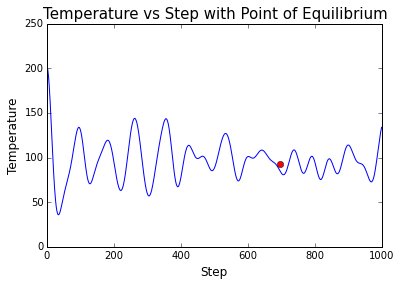

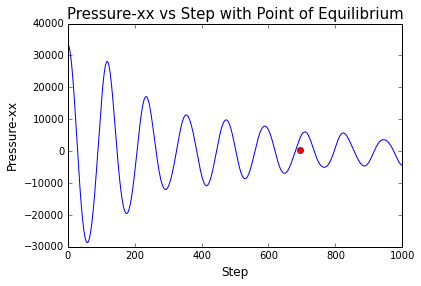

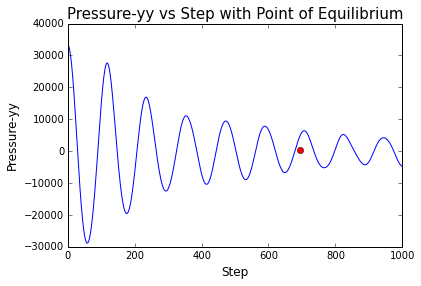

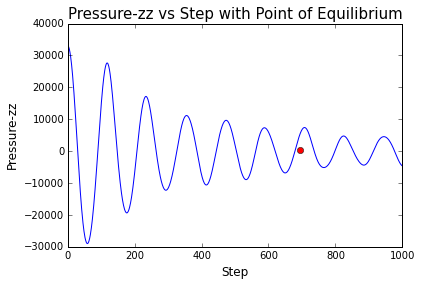

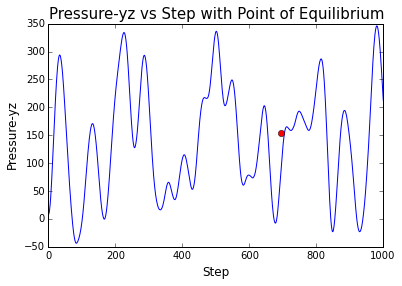

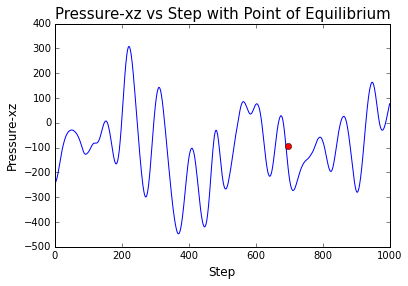

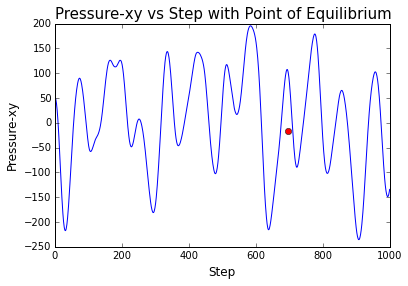

In [21]:
plot(temp, eq_time, eq_temp, 'Temperature')

plot(Pxx, eq_time, eq_pres_xx, 'Pressure-xx')

plot(Pyy, eq_time, eq_pres_yy, 'Pressure-yy')

plot(Pzz, eq_time, eq_pres_zz, 'Pressure-zz')

plot(Pyz, eq_time, eq_pres_yz, 'Pressure-yz')

plot(Pxz, eq_time, eq_pres_xz, 'Pressure-xz')

plot(Pxy, eq_time, eq_pres_xy, 'Pressure-xy')